<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_MA_SES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이동평균(MA) 지수평활(SES/Holt-Winters Simple)

이동평균(MA) 과 지수평활(SES/Holt-Winters Simple) 로 예측하는 Colab용 파이썬 예제입니다.
데이터는 TSLA를 내려받아 학습 80% / 테스트 20% 로 나눠서, 각 방법의 예측과 성능(RMSE/MAE/R²)을 비교합니다.

## * 이동평균: 고정 원점(정적) / 롤링 윈도우 / 확장 윈도우

## * 지수평활(단일지수): 고정 원점(정적) / 롤링 윈도우 / 확장 윈도우



In [10]:
# ============================================
# Colab 준비(필요 시만 실행)
# ============================================
# %pip -q install yfinance statsmodels scikit-learn

import warnings
warnings.filterwarnings("ignore")   # 보기 좋은 출력을 위해 경고 억제

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

plt.rcParams["figure.figsize"] = (12, 5)

# ============================================
# 1) 데이터 로드 (TSLA 종가)
# ============================================
symbol     = "TSLA"
start_date = "2022-01-01"
end_date   = "2024-01-01"

df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)[["Close"]].dropna()
df = df.reset_index()                            # Date 컬럼 보유
df["Date"] = pd.to_datetime(df["Date"])
y = df["Close"].to_numpy(dtype=float)
dates = df["Date"]

# 학습/테스트 분할
train_size  = int(len(y) * 0.8)
y_train = np.asarray(y_train, dtype=float).reshape(-1)
y_test  = np.asarray(y_test,  dtype=float).reshape(-1)
dates_train, dates_test = dates[:train_size], dates[train_size:]

print(f"{symbol}: total={len(y)}, train={len(y_train)}, test={len(y_test)}")




[*********************100%***********************]  1 of 1 completed

TSLA: total=501, train=400, test=101


In [11]:
# ============================================
# 2) 유틸
# ============================================
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(np.mean(np.abs(np.asarray(a) - np.asarray(b))))
def r2(a, b):   return float(r2_score(a, b))

def _as_1d_float(x):
    """어떤 입력이 와도 1D float로 평탄화 + 유한값만 남김"""
    arr = np.asarray(x, dtype=float).reshape(-1)
    return arr[np.isfinite(arr)]

# --------------------------------------------
# 이동평균(MA) 예측기
# --------------------------------------------
def ma_fixed_origin(y_train, test_len, W=10):
    y_train = _as_1d_float(y_train)
    W = max(2, int(W))
    const = float(np.mean(y_train[-W:]))
    return np.full(test_len, const, dtype=float)

def ma_rolling(y_train, y_test, W=10):
    y_train = _as_1d_float(y_train)
    y_test  = _as_1d_float(y_test)
    W = max(2, int(W))

    hist = list(map(float, y_train))  # 숫자 리스트로 고정
    preds = np.empty(len(y_test), dtype=float)

    for i in range(len(y_test)):
        window = hist[-W:] if len(hist) >= W else hist
        preds[i] = float(np.mean(window))     # window는 순수 float 리스트
        hist.append(float(y_test[i]))         # 워크-포워드(실측 주입)
    return preds

def ma_expanding(y_train, y_test):
    y_train = _as_1d_float(y_train)
    y_test  = _as_1d_float(y_test)

    hist = list(map(float, y_train))
    preds = np.empty(len(y_test), dtype=float)

    for i in range(len(y_test)):
        preds[i] = float(np.mean(hist))
        hist.append(float(y_test[i]))
    return preds

# --------------------------------------------
# 지수평활(단일지수, SES) 예측기
# --------------------------------------------
def fit_ses(series, alpha=None):
    series = _as_1d_float(series)
    model = SimpleExpSmoothing(series, initialization_method="heuristic")
    return model.fit(smoothing_level=alpha, optimized=(alpha is None))

def ses_fixed_origin(y_train, test_len, alpha=None):
    fit = fit_ses(y_train, alpha)
    return fit.forecast(test_len).astype(float)

def ses_rolling(y_train, y_test, W=60, alpha=None):
    y_train = _as_1d_float(y_train)
    y_test  = _as_1d_float(y_test)
    W = max(5, int(W))

    hist = list(map(float, y_train))
    preds = np.empty(len(y_test), dtype=float)

    for i in range(len(y_test)):
        window = hist[-W:] if len(hist) >= W else hist
        fit = fit_ses(window, alpha)          # window는 순수 float 리스트
        preds[i] = float(fit.forecast(1)[0])
        hist.append(float(y_test[i]))
    return preds

def ses_expanding(y_train, y_test, alpha=None):
    y_train = _as_1d_float(y_train)
    y_test  = _as_1d_float(y_test)

    hist = list(map(float, y_train))
    preds = np.empty(len(y_test), dtype=float)

    for i in range(len(y_test)):
        fit = fit_ses(hist, alpha)
        preds[i] = float(fit.forecast(1)[0])
        hist.append(float(y_test[i]))
    return preds

In [12]:
# ============================================
# 3) 실행 파라미터
# ============================================
W_ma   = 20   # 이동평균 창
W_ses  = 60   # SES 재적합 창 (롤링 시)
alpha  = None # SES의 α 고정하려면 0<alpha<=1 지정, None이면 최적화
h_full = 20   # full-sample로 미래 h 스텝 예측

# 1) 이동평균(MA, Moving Average)

## 개념

최근 ($W$)개 관측치의 **단순 평균**으로 레벨을 추정하고, 그 값을 다음 시점 예측치로 씁니다.
모든 관측치 가중이 **동일(균등가중)** 이고, 창 밖의 과거는 완전히 버립니다.

## 수식

* 시점 (t)의 이동평균(레벨 추정치):

  
  $$\hat{L}_t \;=\; \frac{1}{W}\sum_{i=0}^{W-1} y_{t-i}$$
  

* 1-step 예측:
  
  $$\hat{y}_{t+1|t}=\hat{L}_t$$
  
* ($h\ge2$) 의 다단계 예측도 **같은 상수**(최근 평균)를 유지합니다.

## 특징

* **지연(Lag)**: 급격한 변화에 느리게 반응(대략 ($W/2$) 시점만큼 뒤늦음).
* **노이즈 감소**는 좋지만 **추세/계절성**을 반영하지 못함(수평선 예측).
* **고정 윈도우**이므로 개념상 “롤링 윈도우 예측”에 아주 자연스럽게 맞음.

## 튜닝(창 길이 ($W$))

* (W)가 크면: 더 매끈(분산↓)하지만 반응 느림(편향↑).
* (W)가 작으면: 반응 빠름(편향↓)하지만 더 요동(분산↑).
* 보통 **롤링 백테스트**로 (W)를 선택합니다.




[MA]  Fixed-origin : RMSE=31.8930 | MAE=27.1462 | R2=-2.3503
[MA]  Rolling      : RMSE=18.4686 | MAE=15.0417 | R2=-0.1235
[MA]  Expanding    : RMSE=17.5055 | MAE=13.8718 | R2=-0.0093


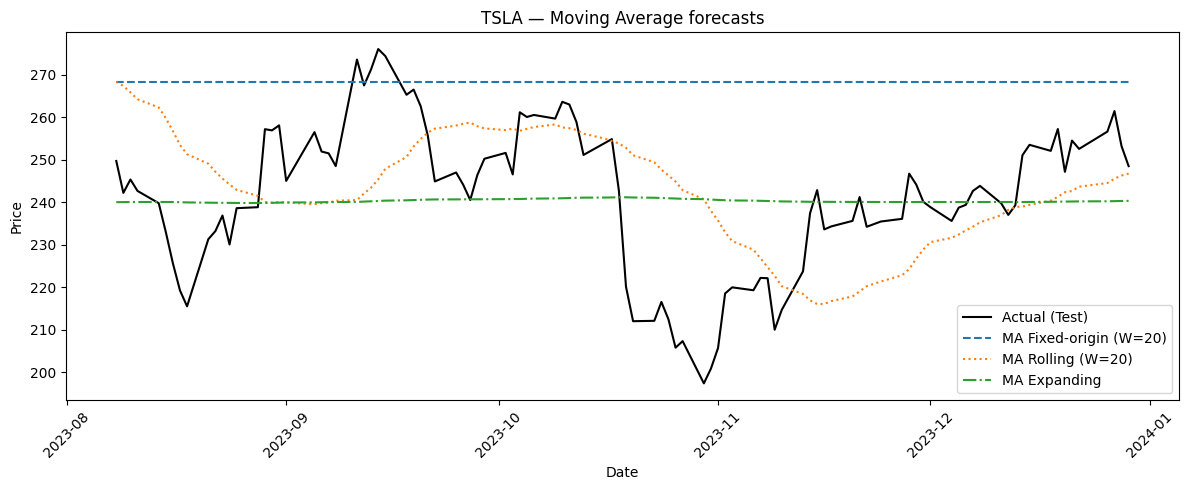

In [13]:
# ============================================
# 4) 이동평균 예측
# ============================================
pred_ma_fix  = ma_fixed_origin(y_train, len(y_test), W=W_ma)
pred_ma_roll = ma_rolling(y_train, y_test, W=W_ma)
pred_ma_exp  = ma_expanding(y_train, y_test)

print("[MA]  Fixed-origin : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ma_fix),  mae(y_test, pred_ma_fix),  r2(y_test, pred_ma_fix)))
print("[MA]  Rolling      : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ma_roll), mae(y_test, pred_ma_roll), r2(y_test, pred_ma_roll)))
print("[MA]  Expanding    : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ma_exp),  mae(y_test, pred_ma_exp),  r2(y_test, pred_ma_exp)))

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_ma_fix,  "--", label=f"MA Fixed-origin (W={W_ma})")
plt.plot(dates_test, pred_ma_roll, ":",  label=f"MA Rolling (W={W_ma})")
plt.plot(dates_test, pred_ma_exp,  "-.", label="MA Expanding")
plt.title(f"{symbol} — Moving Average forecasts")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()



# 2) 지수평활(SES, Single Exponential Smoothing)

(Holt–Winters의 **Simple** 버전; ETS(A,N,N)로도 불림)

## 개념

모든 과거를 쓰되, **가중이 지수적으로 감소**합니다. 최근일수록 더 큰 가중을 주며, 윈도우 경계로 자르지 않습니다.

## 재귀식(가장 많이 쓰는 형태)

* 레벨 추정(평활):

    $$L_t=\alpha y_t + (1-\alpha) L_{t-1}, \qquad 0<\alpha\le1$$

* 1-step 예측:
   
  $$\hat{y}_{t+1|t}=L_t$$
   
* ($h\ge2$) 예측도 ($L_t$)로 **수평선**(추세 없음)입니다.

> 가중 패턴: $(y_t)$에 $(\alpha)$, $(y_{t-1})$에 $(\alpha(1-\alpha))$, $(y_{t-2})$에 $(\alpha(1-\alpha)^2)$, …
> **유효창 길이**는 대략 $(\frac{2}{\alpha}-1)$로 이해하면 직관적입니다.

## 초기화

* $(L_0=y_1)$ 또는 첫 몇 개 평균 등. 실무에선 라이브러리의 **optimized** 옵션을 켭니다.

## ARIMA와의 연결

* SES는 특정 가정 하에서 **$ARIMA(0,1,1)$** 과 동등(예: $(\theta\approx 1-\alpha)$).
  그래서 SES는 **랜덤워크+노이즈** 데이터에 특히 잘 맞습니다.

## 파라미터 $(\alpha)$

* $(\alpha\to1)$: 거의 ‘나이브’(직전값) → 반응 빠름(분산↑, 편향↓)
* $(\alpha\to0)$: 과거에 무거운 가중 → 반응 느림(분산↓, 편향↑)
* 보통 **최대우도/정보기준**으로 자동 추정(예: `statsmodels`의 `optimized=True`).




[SES] Fixed-origin : RMSE=20.0451 | MAE=15.2995 | R2=-0.3234
[SES] Rolling      : RMSE=7.1704 | MAE=5.2777 | R2=0.8307
[SES] Expanding    : RMSE=7.1224 | MAE=5.2836 | R2=0.8329


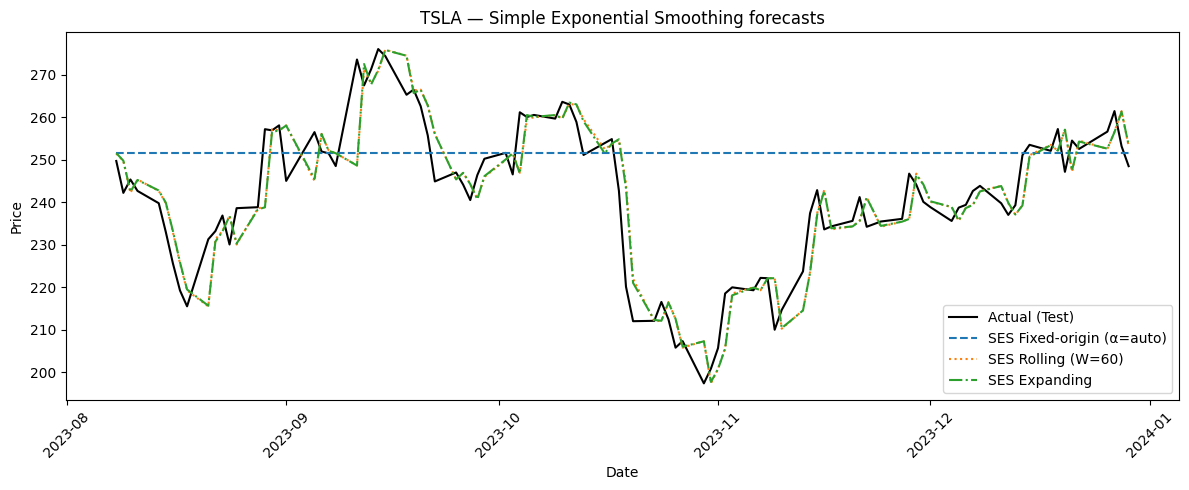

In [14]:
# ============================================
# 5) 지수평활(SES) 예측
# ============================================
pred_ses_fix  = ses_fixed_origin(y_train, len(y_test), alpha=alpha)
pred_ses_roll = ses_rolling(y_train, y_test, W=W_ses, alpha=alpha)
pred_ses_exp  = ses_expanding(y_train, y_test, alpha=alpha)

print("[SES] Fixed-origin : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ses_fix),  mae(y_test, pred_ses_fix),  r2(y_test, pred_ses_fix)))
print("[SES] Rolling      : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ses_roll), mae(y_test, pred_ses_roll), r2(y_test, pred_ses_roll)))
print("[SES] Expanding    : RMSE=%.4f | MAE=%.4f | R2=%.4f" % (rmse(y_test, pred_ses_exp),  mae(y_test, pred_ses_exp),  r2(y_test, pred_ses_exp)))

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_ses_fix,  "--", label=f"SES Fixed-origin (α={'auto' if alpha is None else alpha})")
plt.plot(dates_test, pred_ses_roll, ":",  label=f"SES Rolling (W={W_ses})")
plt.plot(dates_test, pred_ses_exp,  "-.", label="SES Expanding")
plt.title(f"{symbol} — Simple Exponential Smoothing forecasts")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()





# MA vs SES 핵심 비교

| 항목     | 이동평균(MA)            | 지수평활(SES)                             |
| ------ | ------------------- | ------------------------------------- |
| 가중     | 최근 (W)개 **균등**      | 모든 과거에 **지수감쇠** 가중                    |
| 창      | **고정 경계** (창 밖은 버림) | **무경계** (과거 전부 사용)                    |
| 지연     | $\approx(W/2)$              | $(\alpha)$로 조절(유효창 $(\approx2/\alpha-1)$) |
| 추세/계절  | 없음(수평선)             | 없음(수평선)                               |
| 다단계 예측 | 상수                  | 상수                                    |
| 장점     | 단순·안정·설명 쉬움         | 적응적·경계효과 없음·$ARIMA(0,1,1)$와 연결          |
| 단점     | 경계에서 정보 손실, 경직됨     | $(\alpha)$ 선택 민감, 급격한 구조변화엔 한계          |

> **추세**가 있다면 SES가 아닌 **Holt(이중지수평활)**,
> **추세+계절**이면 **Holt–Winters(삼중지수평활, additive/multiplicative)** 를 쓰세요.



# 백테스트 관점(4가지 운용 방식)

두 방법 모두 아래 전략으로 운용할 수 있습니다.

1. **Full-sample(final fit)**: 전체$(1…T)$로 적합 → $T+1…T+h$ 예측(평가용 X, 최종 보고용).
2. **Fixed-origin(holdout)**: $1…N$으로 한 번 적합 → $N+1…T$를 **재적합 없이** 예측.
3. **Rolling-origin + Rolling window**: 원점 이동, MA는 창 $(W)$·SES는 최근 $(W)$만 사용하여 **매 스텝 재적합**.
4. **Rolling-origin + Expanding window**: 원점 이동, **누적 창**으로 **매 스텝 재적합**(안정↑, 적응성↓).



# 실무 팁

* **스케일/결측**: 이상치·결측은 평균 기반 모델에 바로 영향 → 보간/윈저라이즈 권장.
* **창/α 선택**: **롤링 백테스트**로 선택(예: 시계열 CV).
* **예측구간(PI)**: 잔차표준편차 $(\hat\sigma)$로 $(\hat{y}\pm z_{\alpha/2}\hat\sigma)$ 근사(독립·등분산 가정).
* **드리프트/추세**가 보이면 SES/MA는 수평선이므로 **Holt/Holt-Winters/SARIMA** 등으로 승격.


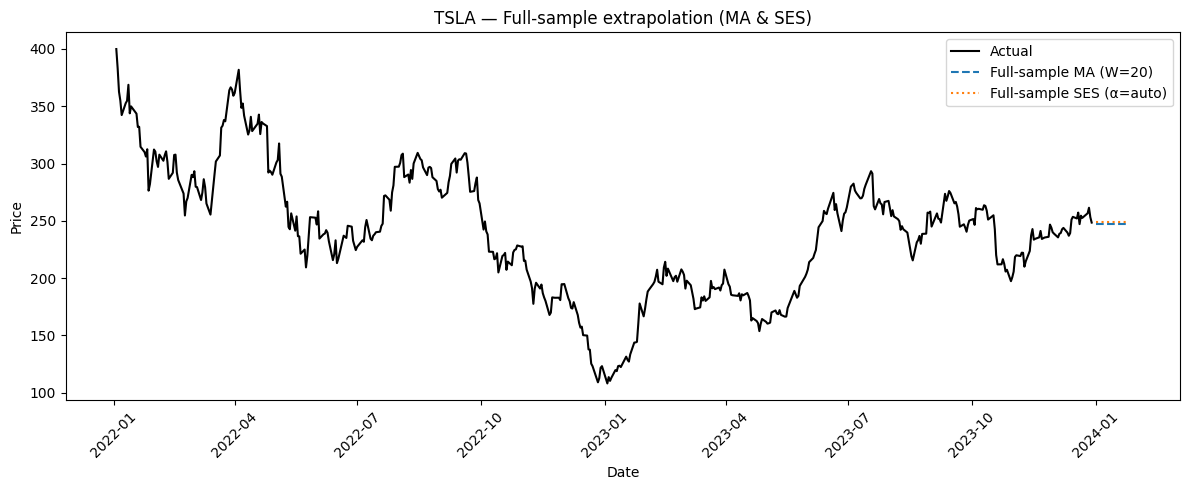

In [15]:
# ============================================
# 6) (보너스) Full-sample(final fit) 외삽
#    - 평가용이 아니라, 전체 데이터로 적합 후 미래 h 스텝 예측
# ============================================
fit_full_ma  = np.mean(y[-W_ma:])                          # 마지막 W개 평균
full_ma_path = np.full(h_full, fit_full_ma, dtype=float)

fit_full_ses = fit_ses(y, alpha=alpha)                     # 전체로 SES 적합
full_ses     = fit_full_ses.forecast(h_full).astype(float)

future_dates = pd.bdate_range(dates.iloc[-1] + pd.Timedelta(days=1), periods=h_full)
plt.figure()
plt.plot(dates, y, color="black", label="Actual")
plt.plot(future_dates, full_ma_path, "--", label=f"Full-sample MA (W={W_ma})")
plt.plot(future_dates, full_ses,     ":",  label=f"Full-sample SES (α={'auto' if alpha is None else alpha})")
plt.title(f"{symbol} — Full-sample extrapolation (MA & SES)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()



In [16]:
# ============================================
# 7) 요약표
# ============================================
summary = pd.DataFrame({
    "Method": [
        f"MA Fixed (W={W_ma})", f"MA Rolling (W={W_ma})", "MA Expanding",
        f"SES Fixed (α={'auto' if alpha is None else alpha})",
        f"SES Rolling (W={W_ses})",
        "SES Expanding"
    ],
    "RMSE": [
        rmse(y_test, pred_ma_fix), rmse(y_test, pred_ma_roll), rmse(y_test, pred_ma_exp),
        rmse(y_test, pred_ses_fix), rmse(y_test, pred_ses_roll), rmse(y_test, pred_ses_exp)
    ],
    "MAE": [
        mae(y_test, pred_ma_fix), mae(y_test, pred_ma_roll), mae(y_test, pred_ma_exp),
        mae(y_test, pred_ses_fix), mae(y_test, pred_ses_roll), mae(y_test, pred_ses_exp)
    ],
    "R2": [
        r2(y_test, pred_ma_fix), r2(y_test, pred_ma_roll), r2(y_test, pred_ma_exp),
        r2(y_test, pred_ses_fix), r2(y_test, pred_ses_roll), r2(y_test, pred_ses_exp)
    ],
})
print("\n=== Summary (lower RMSE/MAE is better; R²→1 is better) ===")
print(summary.sort_values("RMSE").to_string(index=False))


=== Summary (lower RMSE/MAE is better; R²→1 is better) ===
            Method      RMSE       MAE        R2
     SES Expanding  7.122433  5.283644  0.832913
SES Rolling (W=60)  7.170361  5.277716  0.830656
      MA Expanding 17.505496 13.871848 -0.009336
 MA Rolling (W=20) 18.468603 15.041698 -0.123453
SES Fixed (α=auto) 20.045149 15.299471 -0.323444
   MA Fixed (W=20) 31.893031 27.146199 -2.350259
